# Deep Learning &mdash; Assignment 12

Assignment for week 12 of the 2022 Deep Learning course (NWI-IMC070) of the Radboud University.

_Gijs van Tulder (g.vantulder@cs.ru.nl) and Twan van Laarhoven (tvanlaarhoven@cs.ru.nl)_

_December 2022_

-----

**Names:** Hauque, Federico Gabriel - Soler Sanz, Guillem

**Group:** 5

-----

**Instructions:**
* Fill in your names and the name of your group.
* Answer the questions and complete the code where necessary.
* Keep your answers brief, one or two sentences is usually enough.
* Re-run the whole notebook before you submit your work.
* Save the notebook as a PDF and submit that in Brightspace together with the `.ipynb` notebook file.
* The easiest way to make a PDF of your notebook is via File > Print Preview and then use your browser's print option to print to PDF.

## Objectives

In this assignment you will
1. Train a Deep Q Network to play the Cart Pole simulation,
2. Experiment with some of the hyperparameters.

## Required software

As before you will need these libraries:
* `torch` for PyTorch,
* `gym[classic_control]` for the Cart Pole simulation in [OpenAI Gym](https://www.gymlibrary.dev/environments/classic_control/cart_pole/),
* `d2l`, the library that comes with [Dive into deep learning](https://d2l.ai) book.

All libraries can be installed with `pip install`.

In [ ]:
!pip install gym[classic_control]
!pip install --upgrade gym==0.26.2
!pip list | grep gym

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 18.3 MB 58 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 721 kB 5.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gym: filename=gym-0.26.2-py3-none-any.whl size=827648 sha256=7e4826c021a574412296cf20837b080bd734b0ca9495140d985709297dcf7bab
  Stored in directory: /root/.cache/pip/wheels/17/79/65/7afedc162d858b02708a3b8f7a6dd5b1000dcd5b0f894f7cc1
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully uninstalled gym-0.25.2
gym                           0.26.2
gym-notices                   0.0.8


In [ ]:
%config InlineBackend.figure_formats = ['png']
%matplotlib inline

!pip install d2l==1.0.0a1.post0
from d2l import torch as d2l
import random
import math
import itertools
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple, deque
import PIL
import torch
from torch import nn
from torch.nn import functional as F
import torchvision.transforms as T

import gym

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 93 kB 1.1 MB/s 
     |████████████████████████████████| 121 kB 34.6 MB/s 
     |████████████████████████████████| 1.6 MB 69.9 MB/s 
     |████████████████████████████████| 83 kB 2.4 MB/s 


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## 12.1 Cart Pole simulation

In this assignment, you will train a network to play the Cart Pole simulation, a classic control problem that is often used in demonstrations of reinforcement learning.

**(a) Have a look at the [documentation from the OpenAI Gym](https://www.gymlibrary.dev/environments/classic_control/cart_pole/) to understand the inputs and outputs of the Cart Pole problem.**

The interface of the OpenAI Gym works as follows:

step: 0  action: 1  observation: [-0.01322277  0.15558177 -0.02567729 -0.31228012]  reward: 1.0  done: False
step: 1  action: 1  observation: [-0.01011114  0.35105994 -0.03192289 -0.612949  ]  reward: 1.0  done: False
step: 2  action: 1  observation: [-0.00308994  0.5466131  -0.04418187 -0.9155131 ]  reward: 1.0  done: False
step: 3  action: 1  observation: [ 0.00784232  0.74230385 -0.06249213 -1.2217479 ]  reward: 1.0  done: False
step: 4  action: 1  observation: [ 0.0226884   0.9381728  -0.08692709 -1.5333387 ]  reward: 1.0  done: False
step: 5  action: 1  observation: [ 0.04145186  1.1342279  -0.11759386 -1.8518353 ]  reward: 1.0  done: False
step: 6  action: 1  observation: [ 0.06413642  1.3304307  -0.15463057 -2.1785998 ]  reward: 1.0  done: False
step: 7  action: 1  observation: [ 0.09074503  1.5266813  -0.19820257 -2.5147438 ]  reward: 1.0  done: False
step: 8  action: 1  observation: [ 0.12127866  1.7228006  -0.24849744 -2.8610542 ]  reward: 1.0  done: True
step: 9  action: 1  

/usr/local/lib/python3.8/dist-packages/gym/envs/classic_control/cartpole.py:177: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


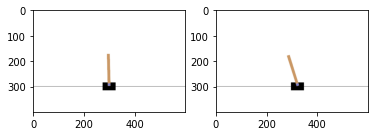

In [ ]:
# create an environment
env = gym.make('CartPole-v1', render_mode='rgb_array')

# reset the simulation
env.reset()

# plot the current state
plt.subplot(1, 2, 1)
plt.imshow(env.render())

# run the simulation for 10 steps
for i in range(10):
    # push the cart to the left (0) or to the right (1)
    action = 1
    observation, reward, done, _, _= env.step(action)
    print(f'step: {i}  action: {action}  observation: {observation}  reward: {reward}  done: {done}')

# plot the new state
plt.subplot(1, 2, 2)
plt.imshow(env.render())

### Creating a visual problem

The standard formulation of the Cart Pole simulation returns observations such as the angle of the pole and the velocity of the cart. We could use these values as the input for our policy network, but this would be fairly simple.

To make the task a bit more complicated, we will give the network the visual representation of the problem. After each step, we render the image, resize, and crop to center on the cart. We then provide this RGB image with the cart in the center as the input for a CNN.

**(b) Run the following code to define a CartPole class that can generate these images.**

In [ ]:
# using code from
# https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

class CartPole:
    def __init__(self, observation_type='screen-diff'):
        '''Initialize the CartPole environment
        
        observation_type:   the type of observations returned by the model:
                            'screen' to return the RGB screen,
                            'screen-diff' to return the (current - previous) screen,
                            'angle' to return the angle of the pole as a float
        '''
        self.observation_type = observation_type
        assert self.observation_type in ('screen', 'screen-diff', 'angle')
        self.env = gym.make('CartPole-v1', render_mode='rgb_array').unwrapped
        self.init_screen_size()

    def reset(self):
        '''Reset the simulation to a random initial state'''
        result = self.env.reset()
        if 'screen' in self.observation_type:
            self.previous_screen = self.get_screen()
            self.current_screen = self.get_screen()
        return result

    def step(self, action):
        '''Perform the given action and run one step of the simulation
        
        action:   0 to move the cart to the left,
                  1 to move the cart to the right
        '''
        result = self.env.step(action)
        if 'screen' in self.observation_type:
            self.previous_screen = self.current_screen
            self.current_screen = self.get_screen()
        return result

    def get_state(self):
        '''Returns the current state of the model
        
        Depending on observation_type, this is either the current RGB screen,
        the difference (current - previous) screen, or the angle of the pole.
        '''
        if self.observation_type == 'screen-diff':
            return self.current_screen - self.previous_screen
        elif self.observation_type == 'screen':
            return self.current_screen
        else:
            assert self.observation_type == 'angle'
            return self.env.state[2]


    resize = T.Compose([T.ToPILImage(),
                        T.Resize(40, interpolation=PIL.Image.BICUBIC),
                        T.ToTensor()])

    def get_cart_location(self, screen_width):
        world_width = self.env.x_threshold * 2
        scale = screen_width / world_width
        return int(self.env.state[0] * scale + screen_width / 2.0)  # MIDDLE OF CART

    def get_screen(self):
        # Returned screen requested by gym is 400x600x3, but is sometimes larger
        # such as 800x1200x3. Transpose it into torch order (CHW).
        screen = self.env.render().transpose((2, 0, 1))
        # Cart is in the lower half, so strip off the top and bottom of the screen
        _, screen_height, screen_width = screen.shape
        screen = screen[:, int(screen_height*0.4):int(screen_height * 0.8)]
        view_width = int(screen_width * 0.6)
        cart_location = self.get_cart_location(screen_width)
        if cart_location < view_width // 2:
            slice_range = slice(view_width)
        elif cart_location > (screen_width - view_width // 2):
            slice_range = slice(-view_width, None)
        else:
            slice_range = slice(cart_location - view_width // 2,
                                cart_location + view_width // 2)
        # Strip off the edges, so that we have a square image centered on a cart
        screen = screen[:, :, slice_range]
        # Convert to float, rescale, convert to torch tensor
        # (this doesn't require a copy)
        screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
        screen = torch.from_numpy(screen)
        # Resize, and add a batch dimension (BCHW)
        return self.resize(screen).unsqueeze(0)

    def init_screen_size(self):
        self.reset()
        _, _, self.screen_height, self.screen_width = self.get_screen().shape

    def plot_screen(self):
        plt.imshow(self.get_screen()[0].numpy().transpose((1, 2, 0)))
        plt.axis('off')

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


**(c) Run the code to initialize the new environment and plot the image of the initial state.**

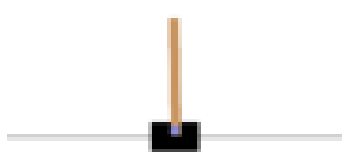

In [ ]:
cartpole = CartPole()
cartpole.reset()
cartpole.plot_screen()

### Running a simulation

First, we will explore the simulation by implementing a few simple policies that take the angle of the pole as input. This will give us a baseline for the performance of our Deep Q Network.

Based on the current state, the policy will push the cart to the left (`action==0`) or to the right (`action==1`).

**(d) Run the code to define a helper function `run_simulation` that can run a simulation given a policy.**

In [ ]:
class ScreenPolicy:
    '''A class for policies that take an image as input.'''
    def select_action(self, screen):
        raise NotImplementedError
    
    def __call__(self, screen):
        return self.select_action(screen)


def run_simulation(policy, plot=True):
    '''Runs a cartpole simulation with the given policy.
    
    The policy is either a function that takes the current angle of the pole,
    or an instance of ScreenPolicy that takes an image of the screen.
    '''
    cartpole = CartPole(observation_type='screen-diff' if isinstance(policy, ScreenPolicy) else 'angle')
    cartpole.reset()
    if plot:
        plt.figure(figsize=(6, 3))
    for step in itertools.count():
        # use the policy to determine the next action
        action = policy(cartpole.get_state())
        # perform the action: 0 for left, 1 for right
        _, reward, done, _, _ = cartpole.step(action)
        if plot and step < 7 * 4:
            plt.subplot(4, 7, step + 1)
            cartpole.plot_screen()
            plt.title(f'{step} {": done" if done else ""}')
        if done:
            break
    if plot:
        plt.tight_layout()
        print(f'Survived for {step} steps')
    return step

## 12.2 Baseline policies (2 points)

To see if our Deep Q Network is any good, we will compare it against three angle-based policies:

* A constant policy that always moves the cart to the right;
* A random policy that picks a random action in each step;
* A policy that decides an action based on the current angle of the pole.

We will run a simulation with each policy and measure how long it runs before the pole falls over.

**(a) Run the code to try the `constant_policy` baseline.**

Survived for 8 steps


8

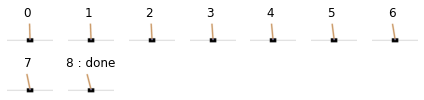

In [ ]:
def constant_policy(angle):
    return 1

run_simulation(constant_policy)

**(b) Implement a `random_policy` that picks a random action in each step.<span style="float:right"> (1 point)</span>**

Survived for 9 steps


9

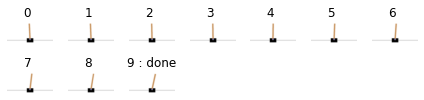

In [ ]:
def random_policy(angle):
    return np.random.randint(0, 1)

run_simulation(random_policy)

**(c) Implement an `angle_policy` that picks the best action based on the current angle of the pole.<span style="float:right"> (1 point)</span>**

Survived for 49 steps


49

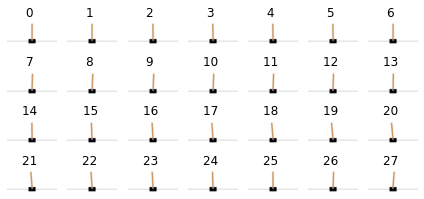

In [ ]:
def angle_policy(angle):
    return 1 if angle > 0 else 0

run_simulation(angle_policy)

As you might have noticed, the performance of the policies is a bit random.

**(d) Compute the average duration over multiple runs to get a good estimate for each policy.**

In [ ]:
def evaluate_policies(policies, runs=50, **kwargs):
    print('Policy               Average survival   Max survival')
    print('----------------------------------------------------')
    for name, policy in policies.items():
        steps = []
        for run in range(runs):
            steps.append(run_simulation(policy, plot=False, **kwargs))
        print('%-24s %6.1f steps   %6d steps' % (name, np.mean(steps), np.max(steps)))

evaluate_policies({'constant': constant_policy,
                   'random':   random_policy,
                   'angle':    angle_policy})

Policy               Average survival   Max survival
----------------------------------------------------
constant                    8.2 steps       10 steps
random                      8.2 steps        9 steps
angle                      43.3 steps       64 steps


<br>
Good. We now have a baseline to compare with, and are ready to implement a Deep Q Network.

## 12.3 Deep Q Network

For each step in the simulation,
* the state is computed as `current screen - previous screen` (showing the changes relative to the previous step);
* the state is given to the Q network;
* the Q network predicts the expected reward for each action,
* we choose the action with the highest expected reward.

**(a) Run the code to define a CNN that takes an image and outputs the expected reward for each action.**

In [ ]:
# using code from
# https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

class DQN(nn.Module):
    def __init__(self, h=cartpole.screen_height, w=cartpole.screen_width,
                 outputs=cartpole.env.action_space.n):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        self.head = nn.Linear(linear_input_size, outputs)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

**(b) Try the network on a single input.**

In [ ]:
policy_net = DQN().to(device)
print(policy_net)
expected_rewards = policy_net(cartpole.get_screen().to(device))
print(expected_rewards)
assert expected_rewards.shape == (1, 2)

DQN(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(2, 2))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (head): Linear(in_features=512, out_features=2, bias=True)
)
tensor([[0.0315, 0.1779]], device='cuda:0', grad_fn=<AddmmBackward0>)


**(c) Define a class to include the network in our experiments.**

In [ ]:
class QNNPolicy(ScreenPolicy):
    def __init__(self, net):
        self.net = net

    def select_action(self, state):
        # compute the expected reward for each action
        with torch.no_grad():
            expected_reward = self.net(state)
        # select the action with the highest score
        return torch.argmax(expected_reward, dim=1).item()

**(d) Try a network with random initialization.**

Survived for 13 steps


13

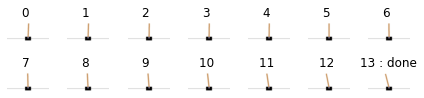

In [ ]:
policy_net = DQN().to(device)
run_simulation(QNNPolicy(policy_net))

In [ ]:
evaluate_policies({'constant':   constant_policy,
                   'random':     random_policy,
                   'angle':      angle_policy,
                   'random qnn': QNNPolicy(policy_net)})

Policy               Average survival   Max survival
----------------------------------------------------
constant                    8.1 steps       10 steps
random                      8.2 steps       10 steps
angle                      40.9 steps       58 steps
random qnn                 13.1 steps       36 steps


## 12.4 Basic reinforcement learning algorithm

We will start with a basic Q learning algorithm (based on code from the [PyTorch Q learning tutorial](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html)).

The algorithm is provided in the slides for this week's lecture.

**(a) Read the code and try to link the components to the Q learning algorithm on the slides.**

In [ ]:
# Data type to represent state transitions
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class QOptimizer_Basic:
    def __init__(self, net, lr=1e-3, batch_size=128, gamma=0.999):
        '''Initialize the algorithm
        
        net:  a policy network that takes the current state s as input
              and returns the Q(s, a) value for each action a
        '''
        self.net = net
        self.gamma = gamma
        self.optimizer = torch.optim.RMSprop(self.net.parameters(), lr=lr)


    # Implements the Q learning algorithm

    def train(self, num_episodes=10, plot=True):
        '''Train the model using a reinforcement learning algorithm
        
        num_episodes:  number of training episodes to run
        plot:          show learning curves during training
        '''
        
        if plot:
            self.init_stats(num_episodes)

        total_steps = 0

        for episode in range(num_episodes):
            # Initialize the environment and state
            cartpole.reset()
            state = cartpole.get_state()

            # Run a single episode until it ends
            for step in itertools.count():
                total_steps += 1

                # Select and perform an action
                action = self.select_action(state, total_steps)
                _, reward, done, _, _ = cartpole.step(action.item())
                reward = torch.tensor([reward], device=device)

                # Observe the new state
                if not done:
                    next_state = cartpole.get_state()
                else:
                    next_state = None

                # Record the transition
                transition = Transition(state, action, next_state, reward)

                # Move to the next state
                state = next_state

                # Perform one step of the optimization:
                # train with the last transition
                self.optimize_model([transition])
                    
                if done:
                    if plot:
                        self.update_stats(episode, step)
                    # Continue to the next episode
                    break


    # The gradient descent optimization step

    def optimize_model(self, transitions):
        '''Run a single optimization step of the model given a set of transitions'''
        
        # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
        # detailed explanation). This converts batch-array of Transitions
        # to Transition of batch-arrays.
        batch = Transition(*zip(*transitions))

        # Concatenate as torch tensors
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)

        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would have
        # been taken for each batch state according to policy_net
        state_action_values = self.net(state_batch).gather(1, action_batch)

        # Compute the expected Q values
        expected_state_action_values = \
            self.compute_expected_state_action_values(batch.next_state, batch.reward)

        # Compute Huber loss
        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.net.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()


    # Helper functions for the algorithm

    def select_action(self, state, total_steps):
        '''Use the network to select the next step given the current state'''
        
        # Compute the expected reward for each action
        with torch.no_grad():
            expected_reward = self.net(state)

        # Select the action with the highest score
        return torch.argmax(expected_reward, dim=1, keepdim=True)

    def compute_expected_state_values(self, states):
        '''Compute Q(s_t+1) for the list of states=[s_t+1]'''
        with torch.no_grad():
            # Use the maximum value of the two possible actions
            return self.net(states).max(1)[0]

    def compute_expected_state_action_values(self, next_states, rewards):
        '''Compute the expected state-action values Q(s_t, a)
        
        Given next_states=[s_{t+1}] and action rewards=[r_a],
        this function returns the expected Q(s_t, a) values.
        '''

        # Compute a mask of non-final states and concatenate the batch elements
        # (a final state would have been the one after which simulation ended)
        non_final_mask = torch.tensor([s is not None for s in next_states],
                                      device=device, dtype=torch.bool)
        if any(non_final_mask):
            non_final_next_states = torch.cat([s for s in next_states if s is not None])
        
        # Compute Q(s_{t+1}) for all next states.
        next_state_values = torch.zeros(len(next_states), device=device)
        if any(non_final_mask):
            next_state_values[non_final_mask] = self.compute_expected_state_values(non_final_next_states).detach()

        # Compute the expected Q(s_t, a) values by adding the action reward.
        next_state_action_values = (next_state_values * self.gamma) + torch.cat(rewards)

        # Return shape: [batch_size]
        return next_state_action_values


    # Plotting code
 
    def init_stats(self, num_episodes):
        '''Initialize the plot and running average'''
        self.animator = d2l.Animator(xlabel='episode', xlim=[1, num_episodes], figsize=(10, 5),
                                     legend=['duration', 'moving average'])
        self.duration_log = deque(maxlen=25)

    def update_stats(self, episode, steps):
        '''Update the moving average and plot the results'''
        
        self.duration_log.append(steps)
        # Plot the results
        if len(self.duration_log) == self.duration_log.maxlen:
            average_duration = np.mean(self.duration_log)
        else:
            average_duration = None
        self.animator.add(episode + 1, (steps, average_duration))

**(b) Train the model.**

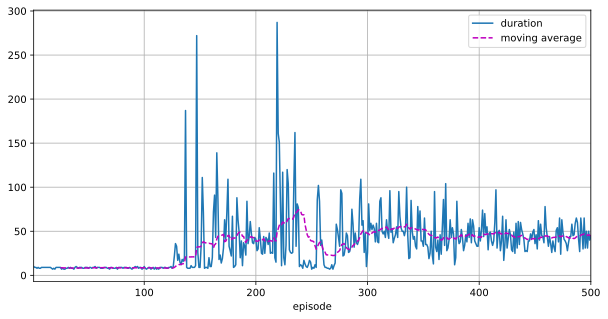

In [ ]:
policy_net = DQN().to(device)
QOptimizer_Basic(policy_net).train(num_episodes=500)

## 12.5 Adding randomness (2 points)

The action selection implemented in `QOptimizer_Basic` is fairly deterministic: we always select the action that is recommended by the network:

$\text{action at time }t = \arg \max_a Q(s_t, a)$

In practice, action selection is often based on an epsilon-greedy algorithm: with a probability $\epsilon$, we choose a random action instead of the action recommended by the algorithm:

$\text{action at time }t = \begin{cases} \arg \max_a Q\left(s_t, a\right) & \text{with probability }1-\epsilon_t \\ \text{a random action }a & \text{with probability }\epsilon_t \end{cases}$

**(a) What is the reason we use this approach?<span style="float:right"> (1 point)</span>**

This approach is used to balance the trade-off between exploration and exploitation. If we focus too much on exploit what is already known about the environment, we will never learn that perhaps we could exploit it better differently. Therefore, we have to allow a certain probability for randomly picking a choice and exploring other potential outcomes from the environment.

**(b) Implement this approach in the `select_action` function of the `QOptimizer_Epsilon` class. <span style="float:right"> (1 point)</span>**

In [ ]:
class QOptimizer_Epsilon(QOptimizer_Basic):
    def __init__(self, *args, eps_start=0.9, eps_end=0.05, eps_decay=2000, **kwargs):
        '''Initialize the algorithm
        
        eps_start:  the initial epsilon value at step 0
        eps_end:    the final epsilon value at step eps_decay
        eps_decay:  the final step of the epsilon decay
        '''
        super().__init__(*args, **kwargs)
        self.eps_start = eps_start
        self.eps_end = eps_end
        self.eps_decay = eps_decay

    def select_action(self, state, total_steps):
        '''Use the network to select the next step given the current state'''
        
        sample = random.random()
        eps_threshold = self.eps_end + (self.eps_start - self.eps_end) * \
                        math.exp(-1. * total_steps / self.eps_decay)
        cartpole.get_state()

        if sample > eps_threshold:
          with torch.no_grad():
            result = torch.argmax(self.net(state), dim=1, keepdim=True)
        else:
          result = torch.tensor([[random.randrange(cartpole.env.action_space.n)]], device=device, dtype=torch.long)
        return result


Later, we will discuss the choice of $\epsilon$. For now, let's see if your implementation works.

**(c) Run an experiment with the default settings.**

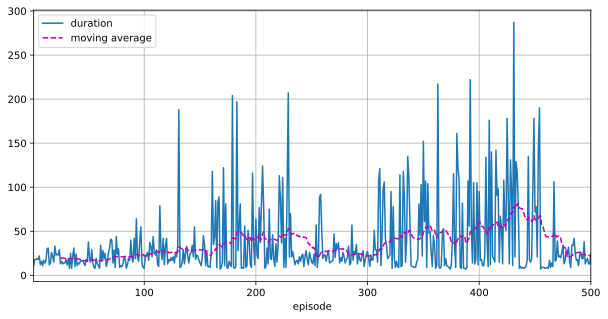

In [ ]:
policy_net = DQN().to(device)
QOptimizer_Epsilon(policy_net).train(num_episodes=500)

## 12.6 Adding memory replay (3 points)

In our basic implementation so far, we
1. perform an action,
2. observe the result, and
3. update the network with that state-action-reward pair.

We will now make our algorithm more efficient and stable by adding memory replay:
1. perform an action,
2. observe the result,
3. add the state-action-reward transition to our replay memory, and
3. update the network using a random minibatch of transitions from the memory.

**(a) Define a memory object to store the last N transitions.**

In [ ]:
class ReplayMemory(object):
    def __init__(self, capacity):
        '''Initialize the replay memory
        
        capacity:  maximum number of transitions to keep
        '''
        self.memory = deque([], maxlen=capacity)

    def push(self, transition):
        '''Save a transition'''
        self.memory.append(transition)

    def sample(self, batch_size):
        '''Select a random subset of batch_size transitions'''
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

**(b) Update the `train` and `optimize_model` functions to add memory replay.<span style="float:right"> (3 points)</span>**

In [ ]:
class QOptimizer_MemoryReplay(QOptimizer_Epsilon):
    def __init__(self, *args, batch_size=128, **kwargs):
        '''Initialize the algorithm
        
        batch_size:  the number of transitions to select from the replay memory
        '''
        super().__init__(*args, **kwargs)
        self.batch_size = batch_size

    def train(self, num_episodes=10, plot=True):
        '''Train the model using a reinforcement learning algorithm
        
        num_episodes:  number of training episodes to run
        plot:          show learning curves during training
        '''
        # TODO Copy the previous train function and add memory replay
        #
        # Things to change:
        #  1. initialize a ReplayMemory object to store the last 10000 transitions
        #  2. after each action, add the transitions to the replay memory
        #  3. pass the replay memory to optimize_model
        if plot:
            self.init_stats(num_episodes)

        total_steps = 0
        memory = ReplayMemory(10000)
        for episode in range(num_episodes):
            # Initialize the environment and state
            cartpole.reset()
            state = cartpole.get_state()

            # Run a single episode until it ends
            for step in itertools.count():
                total_steps += 1

                # Select and perform an action
                action = self.select_action(state, total_steps)
                _, reward, done, _, _ = cartpole.step(action.item())
                reward = torch.tensor([reward], device=device)

                # Observe the new state
                if not done:
                    next_state = cartpole.get_state()
                else:
                    next_state = None

                # Record the transition
                transition = Transition(state, action, next_state, reward)
                memory.push(transition)

                # Move to the next state
                state = next_state

                # Perform one step of the optimization:
                # train with the last transition
                self.optimize_model(memory)
                    
                if done:
                    if plot:
                        self.update_stats(episode, step)
                    # Continue to the next episode
                    break


    def optimize_model(self, memory):
        '''Run a single optimization step with a random subset of the replay memory'''
        
        # Start training when we have enough transitions
        if len(memory) < self.batch_size:
            return
        
        # Select a random subset of the transitions for training
        # TODO Select a sample of batch_size transitions from the replay memory
        transitions = memory.sample(self.batch_size)

        # Train the model on the selected subset
        super().optimize_model(transitions)

**(c) Train a model with the modified algorithm.**

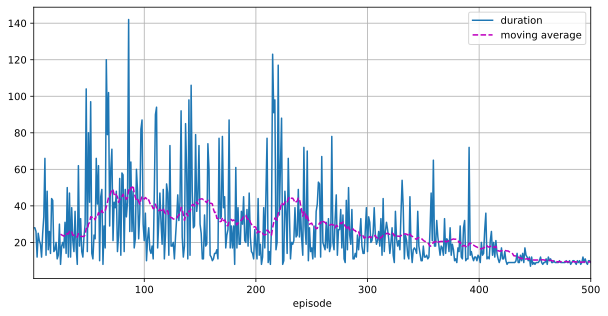

In [ ]:
policy_net = DQN().to(device)
QOptimizer_MemoryReplay(policy_net).train(num_episodes=500)

## 12.7 Adding a target network (3 points)

Finally, we will try to increase the stability of our algorithm by adding a separate target network.

The target network is used to compute the expected $Q(s_{t+1})$ values and updated periodically with the weights of the policy network.

**(a) Complete the new `QOptimizer_Target` class to include the separate target network `target_net`.<span style="float:right"> (3 points)</span>**

In [ ]:
class QOptimizer_Target(QOptimizer_MemoryReplay):
    def __init__(self, net, target_net, *args, update_target_net=500, **kwargs):
        '''Initialize the algorithm
        
        net:                the main policy network
        target_net:         the target network to compute the expected Q(s_t+1) values
        update_target_net:  the number of steps before the policy weights are copied
                            to the target network
        '''
        super().__init__(net, *args, **kwargs)
        self.target_net = target_net
        # Update the target network after a number of steps
        self.update_target_net = update_target_net

        # Initialize the target network as the policy network
        self.target_net.load_state_dict(self.net.state_dict())
        self.target_net.eval()

    def train(self, num_episodes=10, plot=True):
        '''Train the model using a reinforcement learning algorithm
        
        num_episodes:  number of training episodes to run
        plot:          show learning curves during training
        '''
        # TODO Copy the previous train function and add the target network
        #
        # Things to change:
        #  - after every update_target_net steps, synchronize the weights
        #    with the policy network
        if plot:
            self.init_stats(num_episodes)

        total_steps = 0
        memory = ReplayMemory(10000)
        for episode in range(num_episodes):
            # Initialize the environment and state
            cartpole.reset()
            state = cartpole.get_state()

            # Run a single episode until it ends
            for step in itertools.count():
                total_steps += 1

                if total_steps % self.update_target_net == 0:
                  self.target_net.load_state_dict(self.net.state_dict())

                # Select and perform an action
                action = self.select_action(state, total_steps)
                _, reward, done, _, _ = cartpole.step(action.item())
                reward = torch.tensor([reward], device=device)

                # Observe the new state
                if not done:
                    next_state = cartpole.get_state()
                else:
                    next_state = None

                # Record the transition
                transition = Transition(state, action, next_state, reward)
                memory.push(transition)

                # Move to the next state
                state = next_state

                # Perform one step of the optimization:
                # train with the last transition
                self.optimize_model(memory)
                    
                if done:
                    if plot:
                        self.update_stats(episode, step)
                    # Continue to the next episode
                    break
    
    # TODO Make sure the algorithm uses the target network to predict the
    #      Q(s_t+1) values by overriding and changing the right function
    #
    # Hint: It is a small change to the existing implementation.
    def compute_expected_state_values(self, states):
        '''Compute Q(s_t+1) for the list of states=[s_t+1]'''
        with torch.no_grad():
            # Use the maximum value of the two possible actions
            return self.target_net(states).max(1)[0]

**(b) Train a model with the modified algorithm.**

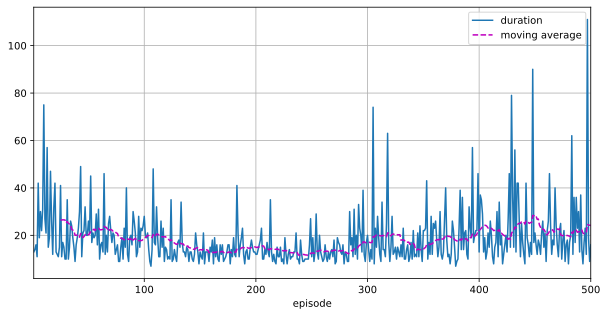

In [ ]:
policy_net = DQN().to(device)
# TODO initialize a target network
target_net = DQN().to(device)
QOptimizer_Target(policy_net, target_net).train(num_episodes=500)

## 12.8 Experiments (10 points)

Let's use the final `QOptimizer_Target` to run a few experiments with the hyperparameters.

### How should we choose gamma?

**(a) What does the parameter gamma do?<span style="float:right"> (1 point)</span>**

The parameter gamma determines the discount rate or the amount of importance given to future rewards. It is used to balance the trade-off between immediate and long-term rewards.

**(b) Train networks with a large and with a small gamma:<span style="float:right"> (1 point)</span>**

* small gamma: `gamma = 0.1`
* large gamma: `gamma = 1.0`

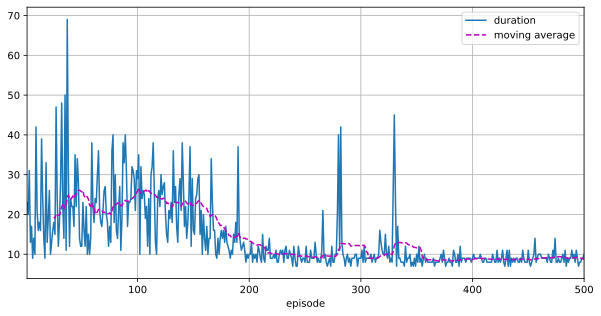

In [ ]:
# TODO Your experiment here.
policy_net = DQN().to(device)
# TODO initialize a target network
target_net = DQN().to(device)
QOptimizer_Target(policy_net, target_net,gamma=0.1).train(num_episodes=500)

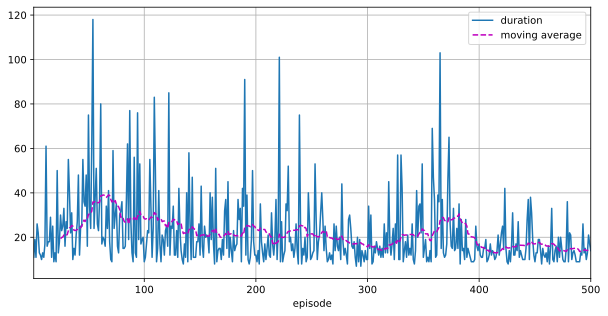

In [ ]:
# TODO Your experiment here.
policy_net = DQN().to(device)
# TODO initialize a target network
target_net = DQN().to(device)
QOptimizer_Target(policy_net, target_net,gamma=1).train(num_episodes=500)

**(c) Discuss the results. Explain what happens if you set gamma very small or very large.<span style="float:right"> (2 points)</span>**

*Gamma small:* If gamma is set very small the rewards from future actions will be given less significance and the agent may behave in a sub-optimal performance , as it will not be able to consider the long-term consequences of its actions.

*Gamma large:* If gamma is set very large, the agent may become overly focused on future rewards and may not take the necessary steps to achieve them. This could lead to sub-optimal performance as the agent may not take the best actions to achieve the desired rewards.

### How should we choose epsilon?

**(d) Train networks with the following settings for epsilon:<span style="float:right"> (1 point)</span>**

* small epsilon: `eps_start = 0.01, eps_end = 0.01`
* large epsilon: `eps_start = 0.9, eps_end = 0.9`

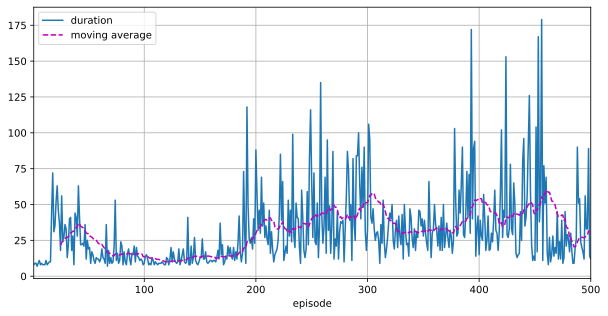

In [ ]:
# TODO Your experiment here.
policy_net = DQN().to(device)
# TODO initialize a target network
target_net = DQN().to(device)
QOptimizer_Target(policy_net, target_net,eps_start = 0.01,eps_end=0.01).train(num_episodes=500)

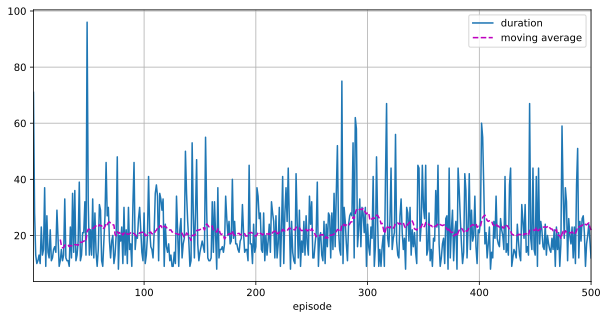

In [ ]:
# TODO Your experiment here.
policy_net = DQN().to(device)
# TODO initialize a target network
target_net = DQN().to(device)
QOptimizer_Target(policy_net, target_net,eps_start = 0.9,eps_end=0.9).train(num_episodes=500)

**(e) Discuss the results. What are the problems of setting epsilon very small or very large?<span style="float:right"> (2 points)</span>**


*Epsilon small:* If the epsilon parameter is set too small, the agent will focus most of the times to exploit the little it knows about the environment and not in exploring other potentially useful actions. However, if it is lucky, in one of its few explorations it could find a proper action to exploit and its performance would grow significantly, though it is unlikely to reach an actual optimal policy.

*Epsilon large:*  On the other hand, if the epsilon parameter is set too large, the agent wil focus mostly on taking random actions and may not be able to learn the optimal policy. 

Therefore, it is important to set the epsilon parameter at a very high level at the beginning to favour exploration, and later reduce it to promote exploitation with what was learned in the previous steps.

### How frequently should we update the target network?

**(f) Train networks with the following settings for the target network:<span style="float:right"> (1 point)</span>**

* updated frequently: every 10 steps
* updated infrequently: every 10000 steps

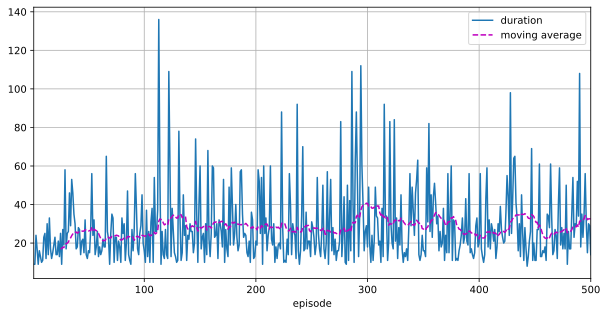

In [ ]:
# TODO Your experiment here.
policy_net = DQN().to(device)
# TODO initialize a target network
target_net = DQN().to(device)
QOptimizer_Target(policy_net, target_net,update_target_net=10).train(num_episodes=500)

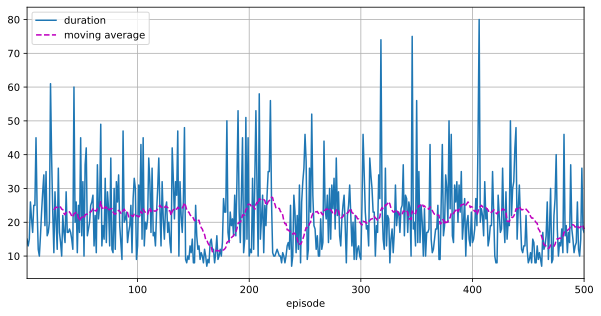

In [ ]:
# TODO Your experiment here.
policy_net = DQN().to(device)
# TODO initialize a target network
target_net = DQN().to(device)
QOptimizer_Target(policy_net, target_net,update_target_net=10000).train(num_episodes=500)

**(g) Discuss the results. What are the problems of updating the target network very quickly or very slowly?<span style="float:right"> (2 points)</span>**


*Frequent updates:* Updating the target network too quickly is very likely to become unstable since the target to which we want to converge is moving constantly and converging to it becomes extremely difficult

*Infrequent updates:* Updating the target network too slowly can lead to the Q-values not being accurate, meaning the agent might take bad actions because it is focusing on converging to a very old target, while the actual one might be far from it. This is easily observed as the moving decreases dramatically after each target network update, and later recovers.


## 12.9 Discussion (7 points)

**(a) What is your observation on the stability of the Q learning algorithm? Does it converge easily?<span style="float:right"> (1 point)</span>**

The Q learning algorithm is considered to be a very stable algorithm, as it converges easily and is not affected by changes in the environment or the learning rate. However, its convergence rate is dependent on the quality of the reward function and the learning rate, so it is important to tune these parameters carefully.

**(b) Compare the loss of the basic model and the model with the target network. How are they computed?<span style="float:right"> (1 point)</span>**

The difference betwen both loss functions is that one profits from a set target function to compute the expected next state actions, while the other just uses the same plain network. When setting the atrget network to a fixed point for several steps we are more likely to achieve convergence. 

**(c) The separate target network is used to make the algorithm more stable. Why is the target network thought to improve stability?<span style="float:right"> (1 point)</span>**

Because when fixing the network, we are more capable of making stable progress to thta specifi target instead of using a constantly changing network that is very likely to diverge due to its rapidly moving targets.

<br>

Let's consider the representation of the input. As you can see in the code and in the plots, the Cart Pole screen is cropped to have the cart always in the center of the image.

**(d) Why is this it convenient for the network to have the cart exactly in the center?<span style="float:right"> (1 point)</span>**

Having the cart exactly in the center of the image provides the network with a consistent frame of reference, which makes it easier to detect changes in the environment. It also simplifies the task of recognizing objects in the image, as the cart is always in the same relative position.

<br>

We do not give the images directly to the network, but compute the difference between the current and previous screens.

**(e) Why would this difference image make the network easier to train?<span style="float:right"> (1 point)</span>**

Most of the image content is useless for our purpose, w only care about how much the pole has rotated in each step and that is exactly what is being considered when computing the difference between images.

<br>

**(f) Suppose that the parameters of the Cart Pole problem change over time (e.g., a strong wind starts blowing from one side of the screen). Would the model be able to adapt to these changes? Explain why, or why not.<span style="float:right"> (2 points)</span>**

The model would be able to adapt and correct the alterations of the wind if it is given enough time. Next state predictions do not taje wind into account, but once it has affected the pole, the algorithm can learn to deal with it fro present and future steps (provided that the target function gets updated frequently enough to realise about the wind on time)

## The end

Well done! Please double check the instructions at the top before you submit your results.

*This assignment has 27 points.*
<span style="float:right;color:#aaa;font-size:10px;"> Version f7e3a73 / 2022-12-07</span>